# Bayesian Linear Regression

Linear regression is a very well known tool, but its bayesian formulation allows to obtain uncertainty estimates for the predictive distribution. This notebook is based on Chapter 3 of Bishop's Pattern Recognition and Machine Learning book.

In [1]:
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
%matplotlib inline

### Generate sample dataset

Generate N pairs $(x_i,y_i)$ with gaussian noise and $x_i$ sampled from uniform distribution

In [2]:
N = 12
sigma = 0.1

In [3]:
x = np.random.uniform(low=-1, high=1, size=N)
n = np.random.normal(loc=0, scale=sigma, size=N)
y = 0.3*x -0.8 +n

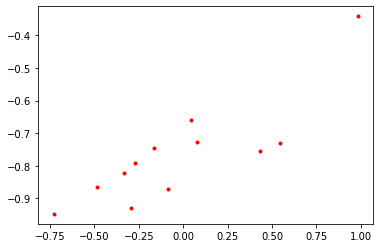

In [4]:
plt.plot(x,y, 'r.');
plt.show()

## Point estimate

We are trying to design a model $\hat{y} = x w_1 + w_0 + \epsilon$ with $\epsilon \sim N(0, \sigma^2)$

Note that this model and noise assumption result in the following likelihood function: $$p(\hat{y}|x,w) = N(xw_1+w_0, \sigma)$$

In general we aim for the Lease Squares (LS) solution: $$\min_w \sum_i (y_i-\hat{y}_i)^2$$

Note that the LS solution is equivalent to the Maximum Likelihood Estimator. The solution can be obtained through minimizing the loss function through Gradient Descent. However, in the case of this simple linear model it is possible to use normal equations (closed form minimization result): $$\hat{w} = (X^TX)^{-1}X^Ty$$

In [5]:
X = np.zeros((x.shape[0], 2))
X[:,0] = x
X[:,1] = 1
X

array([[ 0.07747538,  1.        ],
       [-0.72983355,  1.        ],
       [-0.08385175,  1.        ],
       [ 0.04152017,  1.        ],
       [-0.27236207,  1.        ],
       [-0.16471106,  1.        ],
       [ 0.43409736,  1.        ],
       [-0.33582112,  1.        ],
       [-0.48323886,  1.        ],
       [ 0.54369188,  1.        ],
       [-0.29194542,  1.        ],
       [ 0.98406384,  1.        ]])

In [6]:
w = np.dot(np.dot(np.linalg.inv(np.dot(X.T,X)), X.T), y)
w

array([ 0.28106915, -0.75913605])

However, this solution only provides a point estimate and lacks uncertainity information.

## Bayesian inference

In turn, a bayesian approach treat $w$ as a RV which has a prior. Then, bayesian inference is used to obtain the posterior $p(w|X,Y)$ given observations

In order to keep the solutions in closed-form, we use a Gaussian prior, allowing for a conjugate prior, for the vector $w$ $$w \sim N(w| m_0, S_0)$$ 

Which then results in a Gaussian posterior

$$p(w|X,Y) = \frac{p(Y|X,w)p(w)}{p(Y|X)} = N(w| m_N, S_N)$$ where $m_N = S_N (S_0^{-1}m_0+\frac{1}{\sigma}X^Ty)$ and $S_N^{-1} = S_0^{-1}+\frac{1}{\sigma}X^TX$

For simplicity, let's assume $m_0 = 0$ and $S_0 = \alpha^{-1}I = 0.5I$

In [7]:
#prior parameters
a = 0.2
m0 = np.zeros(2)

In [8]:
def getPosterior(n):
    #Get n points from sample dataset
    x_ = X[:n]
    y_ = y[:n]
    
    #Covariance Matrix
    S0I = a*np.identity(2)
    SnI = S0I+ 1/sigma*np.dot(x_.T,x_)
    Sn = np.linalg.inv(SnI)
    
    #Mean
    tt = np.dot(S0I, m0) + 1/sigma*np.dot(x_.T,y_)
    Mn = np.dot(Sn, tt)
    return multivariate_normal(mean=Mn, cov=Sn)

In [9]:
def plot_dist2D(dist):
    x, y = np.mgrid[-1:1:.01, -1:1:.01]
    pos = np.empty(x.shape + (2,))
    pos[:, :, 0] = y; pos[:, :, 1] = x
    plt.contourf(x, y, dist.pdf(pos))
    plt.title('Posterior Distribution $p(w|X,Y)$')
    plt.xlabel('w0')
    plt.ylabel('w1')

#### Posterior distribution plots

We can plot the posterior after aggregating different number of points. Observe how the posterior distributions become narrower when more observation are aggregated

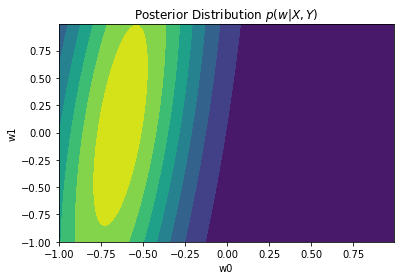

In [10]:
plot_dist2D(getPosterior(1))

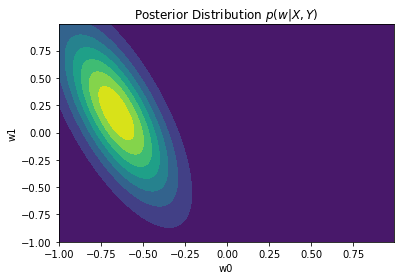

In [11]:
plot_dist2D(getPosterior(4))

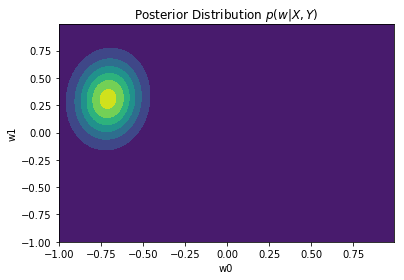

In [12]:
plot_dist2D(getPosterior(6))

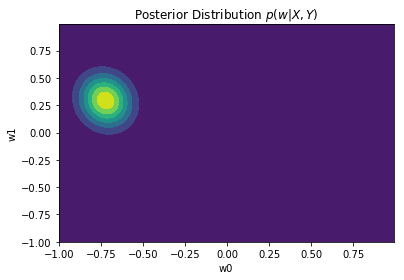

In [13]:
plot_dist2D(getPosterior(10))

The full posterior (when all points are incorporated) will have a peak on the mean, $w_{MAP} = m_N$, given the Gaussian distribution. In the case where the prior $p(w)$ is infinitely spread ($a \to 0$), $w_{MAP} = m_N = w_{ML} = (X^TX)^{-1}X^Ty$

#### The predictive distribution

Although we have estimated the posterior of parameters $w$, we are primarily interested in predicting the value of $\hat{y}$ for new sample x: $$p(\hat{y}| x, X,Y) = \int p(y|w)p(w|X,Y) dw$$

Given the likelihood and posterior following Gaussian distributions, this predicitive distribution is also Gaussian: $$p(\hat{y}| x, X,Y) = N(\hat{y}| m_N^Tx, \sigma_N^2(x))$$ where $ \sigma_N^2(x) = \sigma^2 + x^TS_Nx $

Note that the variance of the predictive distribution depends both on the assumed noise model ($\sigma$) and the uncertainty on the $w$ posterior

In [14]:
def predictive(x, nTrainingSamples):
    xp = np.zeros((2,1))
    xp[0,0] = x
    xp[1,0] = 1
    xp = np.matrix(xp)
    
    #Get posterior given nTrainingSamples
    posterior = getPosterior(nTrainingSamples)
    Mn = np.matrix(posterior.mean)
    Sn = np.matrix(posterior.cov)
    
    #Predictive mean   
    m = np.matmul(Mn,xp)
    
    #Predictive cov
    s = sigma**2 + np.dot(xp.T, np.dot(Sn,xp))
    return multivariate_normal(mean=m, cov=s)    

In [15]:
def plot_dist1D(dist):
    x = np.linspace(-4,4, 100)
    y = dist.pdf(x)
    plt.plot(y,x)
    plt.title('Predictive Distribution $p(\hat{y}|x, X,Y)$')
    plt.xlabel('pdf')
    plt.ylabel('$\hat{y}$')

#### We now observe how the predictive distributions become more certain as more training data is obtained

In [16]:
#New values of x where we want to predict y
x = 1.2

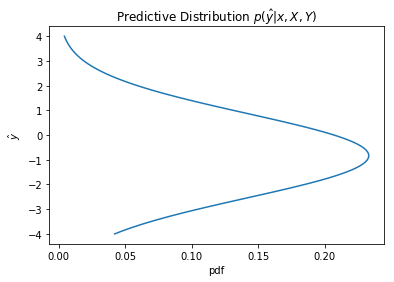

In [17]:
plot_dist1D(predictive(x, 2))

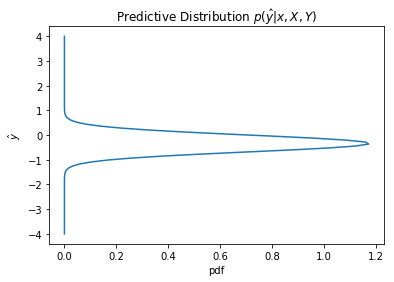

In [18]:
plot_dist1D(predictive(x, 6))

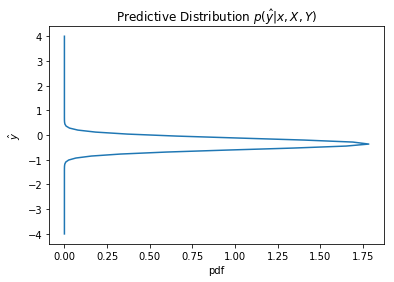

In [19]:
plot_dist1D(predictive(x, 12))

#### We would also observe how the uncertainity changes with the values of x

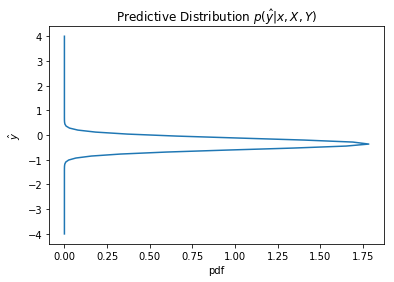

In [20]:
plot_dist1D(predictive(1.2, 12))

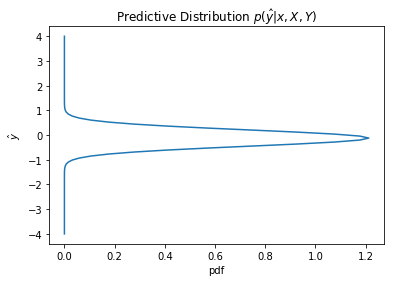

In [25]:
plot_dist1D(predictive(2, 12))

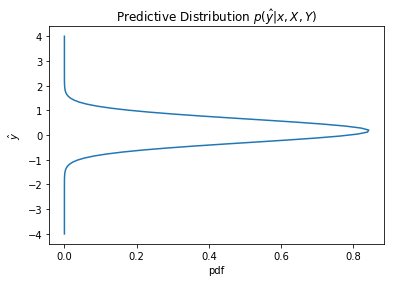

In [26]:
plot_dist1D(predictive(3, 12))

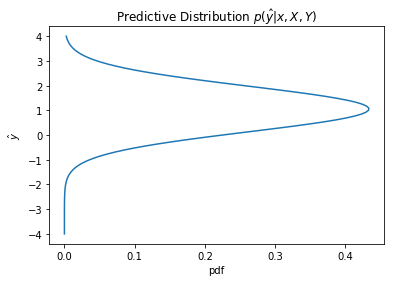

In [27]:
plot_dist1D(predictive(6, 12))

The predictive distribution variance grows as x increases, as expected from $\sigma_N(x)$